In [16]:
# Import required libraries
import ee
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats, signal
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')

C:\Users\dhani\AppData\Local\Temp\ipykernel_22856\1806844732.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
# Initialize Earth Engine
ee.Initialize(project="ee-deepeshy")

# Define study area (Chennai)
CITY_COORDS = [80.2707, 13.0827]  # [longitude, latitude]
CITY_POINT = ee.Geometry.Point(CITY_COORDS)
REGION = CITY_POINT.buffer(10000)  # 10km buffer


# Set date range
END_DATE = datetime.now()
START_DATE = END_DATE - timedelta(days=5*365)  # 5 years of data

In [18]:
def get_ndvi_data(start_date, end_date):
    print("Collecting NDVI data...")
    
    def calculate_ndvi_l8(image):
        # Calculate NDVI
        ndvi = image.normalizedDifference(['B5', 'B4']).rename('NDVI')
        # Use QA_PIXEL band instead of BQA for cloud masking
        qa = image.select('QA_PIXEL')
        # Mask for clear pixels (bit 3 is cloud, bit 4 is cloud shadow)
        clear = qa.bitwiseAnd(1 << 3).eq(0).And(qa.bitwiseAnd(1 << 4).eq(0))
        return ndvi.updateMask(clear)

    dates = pd.date_range(start=start_date, end=end_date, freq='M')
    ndvi_values = []
    
    for date in dates:
        start_month = date.strftime('%Y-%m-01')
        end_month = (date + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        
        try:
            # Get NDVI collection for the month
            ndvi_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA') \
                .filterBounds(REGION) \
                .filterDate(start_month, end_month) \
                .filter(ee.Filter.lt('CLOUD_COVER', 50))
            
            # Check if we have any images
            count = ndvi_collection.size().getInfo()
            
            if count > 0:
                # Calculate NDVI first, then reduce region
                ndvi_image = ndvi_collection.map(calculate_ndvi_l8) \
                    .mean()
                
                ndvi_value = ndvi_image.reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=REGION,
                    scale=30,
                    maxPixels=1e9
                ).get('NDVI').getInfo()
                
                if ndvi_value is not None:
                    ndvi_values.append(ndvi_value)
                else:
                    print(f"No valid NDVI values for {date}")
                    ndvi_values.append(None)
            else:
                print(f"No images found for {date}")
                ndvi_values.append(None)
            
        except Exception as e:
            print(f"Error processing NDVI for {date}: {str(e)}")
            ndvi_values.append(None)
    
    df = pd.DataFrame({
        'date': dates,
        'NDVI': ndvi_values
    })
    
    # Handle missing values with interpolation
    df['NDVI'] = df['NDVI'].interpolate(method='linear', limit_direction='both')
    
    # Print summary statistics
    valid_values = df['NDVI'].dropna()
    if len(valid_values) > 0:
        print(f"NDVI data collection completed.")
        print(f"Number of valid values: {len(valid_values)}")
        print(f"Range: {valid_values.min():.3f} to {valid_values.max():.3f}")
        print(f"Mean: {valid_values.mean():.3f}")
    else:
        print("Warning: No valid NDVI values collected!")
    
    return df


def get_temperature_data(start_date, end_date):
    print("Collecting temperature data...")
    
    dates = pd.date_range(start=start_date, end=end_date, freq='M')
    temp_values = []
    
    for date in dates:
        start_month = date.strftime('%Y-%m-01')
        end_month = (date + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        
        try:
            era5_data = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY") \
                .filterDate(start_month, end_month) \
                .select('temperature_2m') \
                .mean() \
                .reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=REGION,
                    scale=1000,
                    maxPixels=1e9
                ).get('temperature_2m').getInfo()
            
            # Convert from Kelvin to Celsius
            if era5_data is not None:
                temp_values.append(era5_data - 273.15)
            else:
                temp_values.append(None)
                
        except Exception as e:
            print(f"Error collecting temperature for {date}: {str(e)}")
            temp_values.append(None)
    
    df = pd.DataFrame({
        'date': dates,
        'temperature': temp_values
    })
    
    # Handle missing values
    df['temperature'] = df['temperature'].interpolate(method='linear', limit_direction='both')
    
    print(f"Temperature data collection completed. Range: {df['temperature'].min():.1f}°C to {df['temperature'].max():.1f}°C")
    return df

def get_rainfall_data(start_date, end_date):
    print("Collecting rainfall data...")
    
    dates = pd.date_range(start=start_date, end=end_date, freq='M')
    precip_values = []
    
    for date in dates:
        # Get start and end of month
        start_month = date.strftime('%Y-%m-01')
        end_month = (date + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        
        # Get CHIRPS data for the month
        chirps_data = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
            .filterDate(start_month, end_month) \
            .sum() \
            .reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=REGION,
                scale=500,
                maxPixels=1e9
            ).get('precipitation').getInfo()
        
        precip_values.append(chirps_data if chirps_data is not None else None)
    
    df = pd.DataFrame({
        'date': dates,
        'precipitation': precip_values
    })
    
    # Handle any None values through interpolation
    df['precipitation'] = df['precipitation'].interpolate(method='linear', limit_direction='both')
    
    return df

def get_air_quality_data(start_date, end_date):
    print("Collecting air quality data...")
    
    dates = pd.date_range(start=start_date, end=end_date, freq='M')
    no2_values = []
    aer_values = []
    
    for date in dates:
        # Get start and end of month
        start_month = date.strftime('%Y-%m-01')
        end_month = (date + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        
        # Get NO2 data
        no2_data = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_NO2') \
            .filterDate(start_month, end_month) \
            .select('NO2_column_number_density') \
            .mean() \
            .reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=REGION,
                scale=1000,
                maxPixels=1e9
            ).get('NO2_column_number_density').getInfo()
        
        # Get Aerosol data
        aer_data = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_AER_AI') \
            .filterDate(start_month, end_month) \
            .select('absorbing_aerosol_index') \
            .mean() \
            .reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=REGION,
                scale=1000,
                maxPixels=1e9
            ).get('absorbing_aerosol_index').getInfo()
        
        no2_values.append(no2_data if no2_data is not None else None)
        aer_values.append(aer_data if aer_data is not None else None)
    
    df = pd.DataFrame({
        'date': dates,
        'aqi_no2': no2_values,
        'aqi_aer': aer_values
    })
    
    # Handle any None values through interpolation
    df['aqi_no2'] = df['aqi_no2'].interpolate(method='linear', limit_direction='both')
    df['aqi_aer'] = df['aqi_aer'].interpolate(method='linear', limit_direction='both')
    
    return df

In [19]:
def validate_data(df):
    print("\nData Validation:")
    print("-" * 50)
    
    for column in df.select_dtypes(include=[np.number]).columns:
        values = df[column].values
        n_unique = len(np.unique(values))
        std = np.std(values)
        
        print(f"\nColumn: {column}")
        print(f"Number of unique values: {n_unique}")
        print(f"Standard deviation: {std:.6f}")
        print(f"Range: {np.min(values):.6f} to {np.max(values):.6f}")
        print(f"Missing values: {df[column].isna().sum()}")
        
        # Additional checks
        if n_unique == 1:
            print("WARNING: Column has only one unique value!")
        if std < 1e-6:
            print("WARNING: Column has very low variation!")
        
        # Plot the time series
        plt.figure(figsize=(12, 4))
        plt.plot(df['date'], df[column], 'o-')
        plt.title(f'Time Series of {column}')
        plt.xlabel('Date')
        plt.ylabel(column)
        plt.grid(True)
        plt.show()

In [20]:
def analyze_missing_values(df):
    # Calculate missing value statistics
    total_records = len(df)
    missing_stats = pd.DataFrame({
        'Total Records': total_records,
        'Missing Values': df.isnull().sum(),
        'Missing Percentage': (df.isnull().sum() / total_records * 100).round(2),
        'Available Records': df.count(),
        'Coverage Percentage': (df.count() / total_records * 100).round(2)
    })
    
    print("\nMissing Value Analysis:")
    display(missing_stats)
    
    # Identify temporal gaps
    df_sorted = df.sort_values('date')
    time_gaps = []
    
    for col in df.columns:
        if col != 'date':
            # Find gaps larger than 1 month
            non_null_dates = df_sorted[df_sorted[col].notnull()]['date']
            gaps = non_null_dates.diff()
            large_gaps = gaps[gaps > pd.Timedelta(days=30)]
            
            if not large_gaps.empty:
                print(f"\nTemporal gaps in {col}:")
                for gap in large_gaps:
                    print(f"Gap of {gap.days} days")

Starting data collection...
No images found for 2020-06-30 00:00:00
No images found for 2020-08-31 00:00:00
No images found for 2020-09-30 00:00:00
No images found for 2021-06-30 00:00:00
No images found for 2021-11-30 00:00:00
No images found for 2022-03-31 00:00:00
No images found for 2022-06-30 00:00:00
No images found for 2022-08-31 00:00:00
No images found for 2022-09-30 00:00:00
No images found for 2022-11-30 00:00:00
NDVI data collection completed.
Number of valid values: 36
Range: -0.161 to 0.281
Mean: 0.087
Temperature data collection completed. Range: 24.4°C to 31.3°C

Data Validation:
--------------------------------------------------

Column: NDVI
Number of unique values: 36
Standard deviation: 0.069674
Range: -0.160973 to 0.281007
Missing values: 0


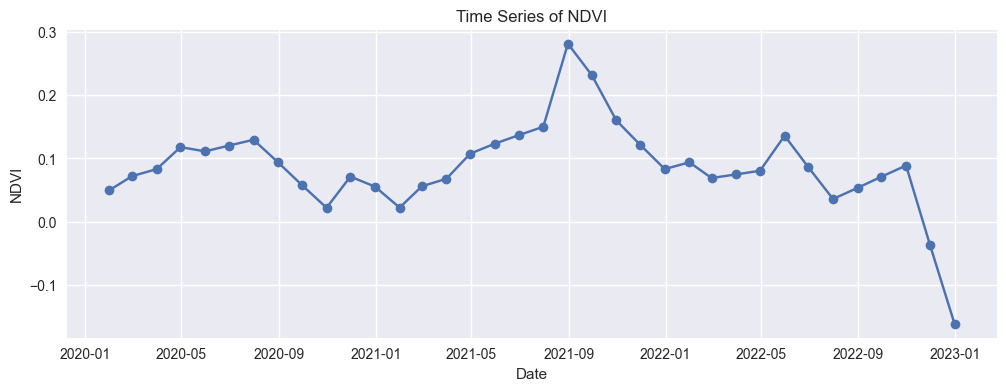


Column: precipitation
Number of unique values: 35
Standard deviation: 221.742426
Range: 0.000000 to 1112.384602
Missing values: 0


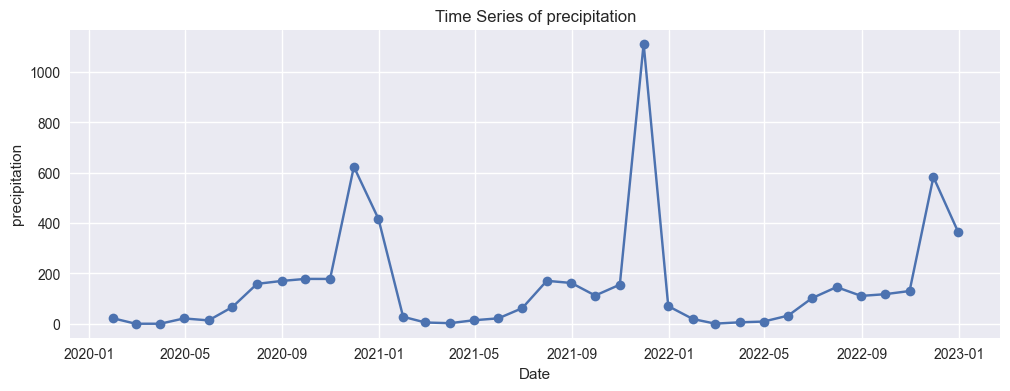


Column: temperature
Number of unique values: 36
Standard deviation: 2.100423
Range: 24.366075 to 31.318173
Missing values: 0


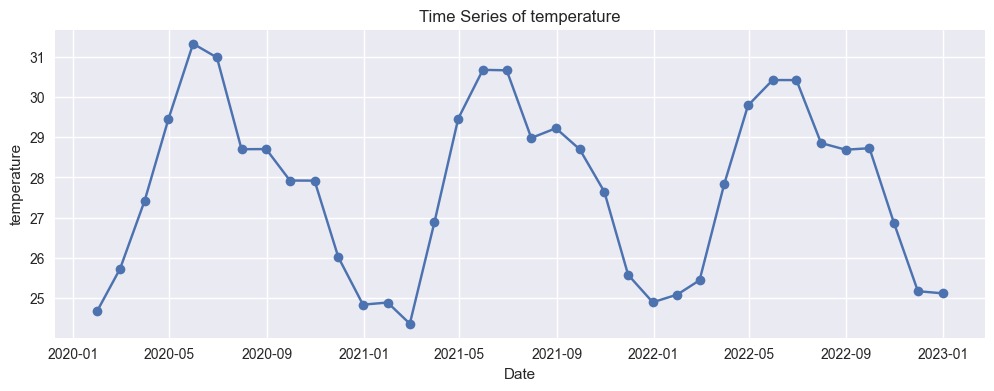


Column: aqi_no2
Number of unique values: 36
Standard deviation: 0.000014
Range: 0.000056 to 0.000113
Missing values: 0


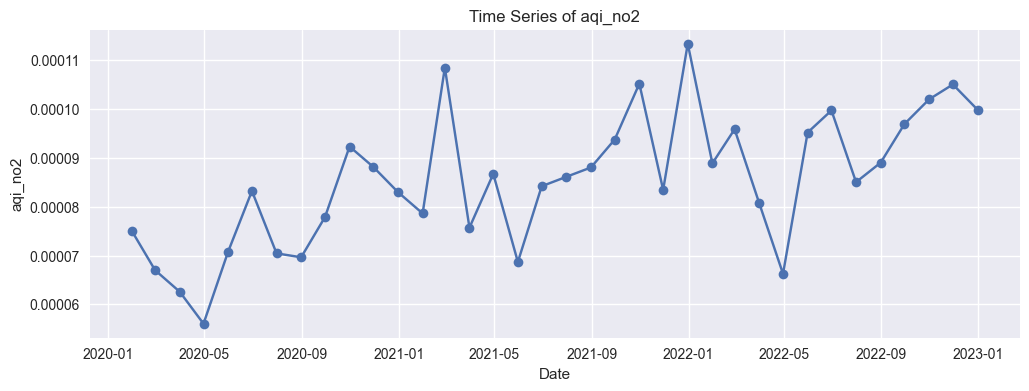


Column: aqi_aer
Number of unique values: 36
Standard deviation: 0.555004
Range: -1.744892 to 0.205600
Missing values: 0


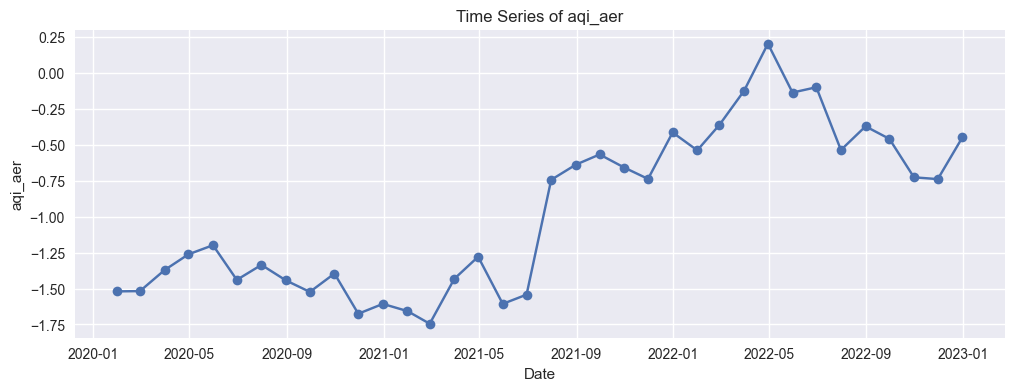


Summary Statistics:
                      date       NDVI  precipitation  temperature    aqi_no2  \
count                   36  36.000000      36.000000    36.000000  36.000000   
mean   2021-07-15 21:20:00   0.086553     149.417950    27.722831   0.000085   
min    2020-01-31 00:00:00  -0.160973       0.000000    24.366075   0.000056   
25%    2020-10-23 06:00:00   0.057358      17.450737    25.545961   0.000076   
50%    2021-07-15 12:00:00   0.083119      85.654913    27.920114   0.000086   
75%    2022-04-07 12:00:00   0.120562     163.861608    29.278327   0.000095   
max    2022-12-31 00:00:00   0.281007    1112.384602    31.318173   0.000113   
std                    NaN   0.070662     224.887866     2.130218   0.000014   

         aqi_aer  
count  36.000000  
mean   -0.961538  
min    -1.744892  
25%    -1.462118  
50%    -0.970162  
75%    -0.515301  
max     0.205600  
std     0.562877  


In [21]:
# Set date range
START_DATE = '2020-01-01'
END_DATE = '2023-01-01'

# Collect data
print("Starting data collection...")
ndvi_df = get_ndvi_data(START_DATE, END_DATE)
rainfall_df = get_rainfall_data(START_DATE, END_DATE)
temp_df = get_temperature_data(START_DATE, END_DATE)
aqi_df = get_air_quality_data(START_DATE, END_DATE)

# Merge all data
all_data = ndvi_df.merge(rainfall_df, on='date', how='outer') \
    .merge(temp_df, on='date', how='outer') \
    .merge(aqi_df, on='date', how='outer')

# Sort by date
all_data = all_data.sort_values('date')

# Validate the data
validate_data(all_data)

# Print summary statistics
print("\nSummary Statistics:")
print(all_data.describe())

In [22]:
# Merge all datasets
df = ndvi_df.merge(temp_df, on='date', how='outer')
df = df.merge(rainfall_df, on='date', how='outer')
df = df.merge(aqi_df, on='date', how='outer')
df = df.sort_values('date')

# Display initial data overview
print("\nInitial Data Overview:")
display(df.head())
print("\nBasic Statistics:")
display(df.describe())


Initial Data Overview:


,date,NDVI,temperature,precipitation,aqi_no2,aqi_aer
0,2020-01-31,0.049453,24.674856,22.157360,0.000075,-1.519536
1,2020-02-29,0.072008,25.731220,0.000000,0.000067,-1.517674
2,2020-03-31,0.083049,27.422403,0.000000,0.000063,-1.371175
3,2020-04-30,0.117838,29.453381,21.061498,0.000056,-1.261589
4,2020-05-31,0.111071,31.318173,13.234773,0.000071,-1.197920



Basic Statistics:


,date,NDVI,temperature,precipitation,aqi_no2,aqi_aer
count,36,36.000000,36.000000,36.000000,36.000000,36.000000
mean,2021-07-15 21:20:00,0.086553,27.722831,149.417950,0.000085,-0.961538
min,2020-01-31 00:00:00,-0.160973,24.366075,0.000000,0.000056,-1.744892
25%,2020-10-23 06:00:00,0.057358,25.545961,17.450737,0.000076,-1.462118
50%,2021-07-15 12:00:00,0.083119,27.920114,85.654913,0.000086,-0.970162
75%,2022-04-07 12:00:00,0.120562,29.278327,163.861608,0.000095,-0.515301
max,2022-12-31 00:00:00,0.281007,31.318173,1112.384602,0.000113,0.205600
std,NaN,0.070662,2.130218,224.887866,0.000014,0.562877


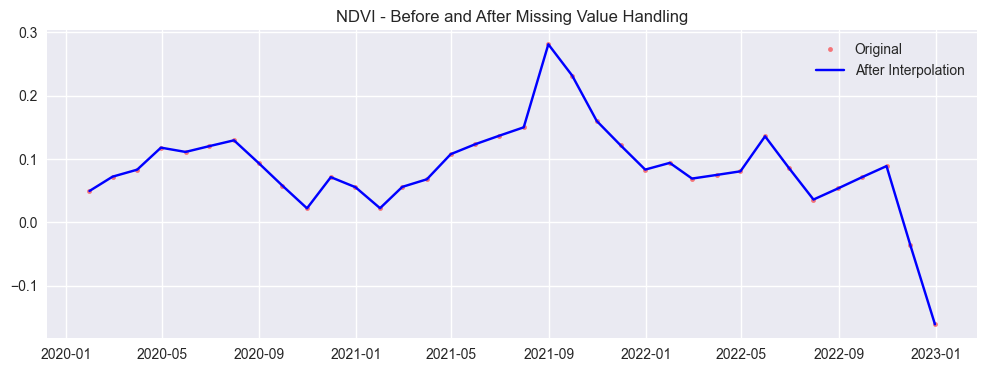

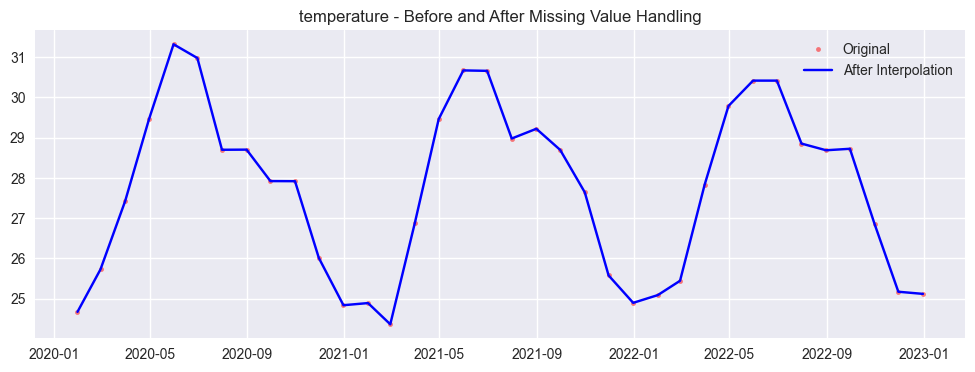

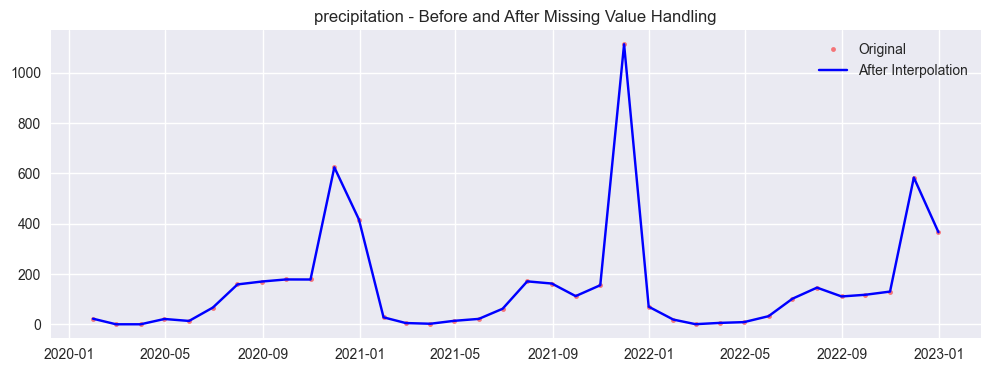

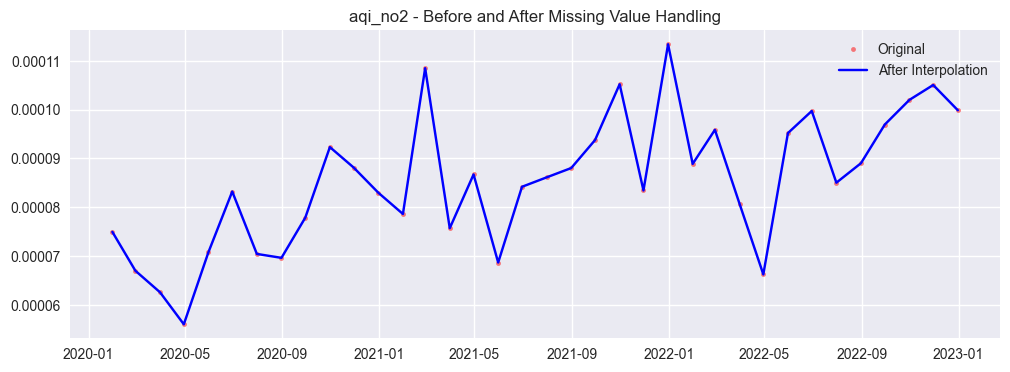

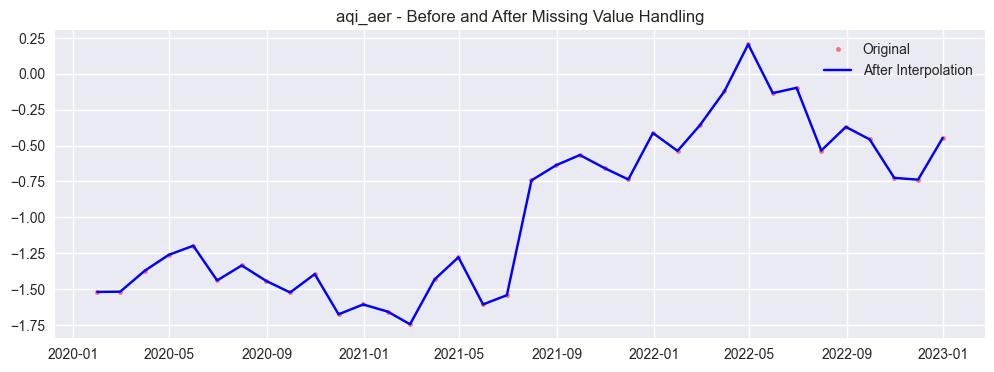

In [23]:
# Preprocessing Step 1: Handle Missing Values
def handle_missing_values(df):
    df_cleaned = df.copy()
    
    for column in df_cleaned.select_dtypes(include=[np.number]).columns:
        # Linear interpolation
        df_cleaned[column] = df_cleaned[column].interpolate(method='linear')
        # Handle edges
        df_cleaned[column] = df_cleaned[column].fillna(method='bfill').fillna(method='ffill')
    
    return df_cleaned

df_cleaned = handle_missing_values(df)

variables = ['NDVI', 'temperature', 'precipitation', 'aqi_no2','aqi_aer']
# Visualize the effect of missing value handling
for var in variables:
    plt.figure(figsize=(12, 4))
    plt.plot(df['date'], df[var], 'r.', label='Original', alpha=0.5)
    plt.plot(df_cleaned['date'], df_cleaned[var], 'b-', label='After Interpolation')
    plt.title(f'{var} - Before and After Missing Value Handling')
    plt.legend()
    plt.show()

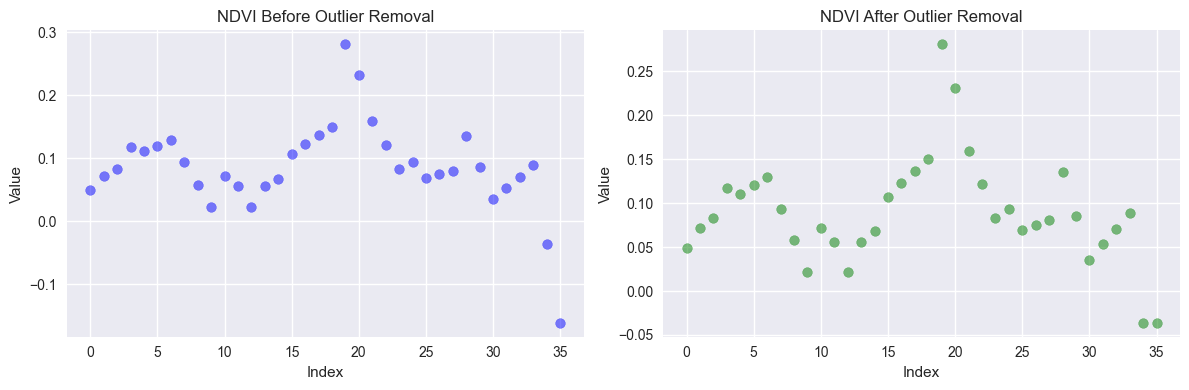

Number of outliers removed in NDVI: 1


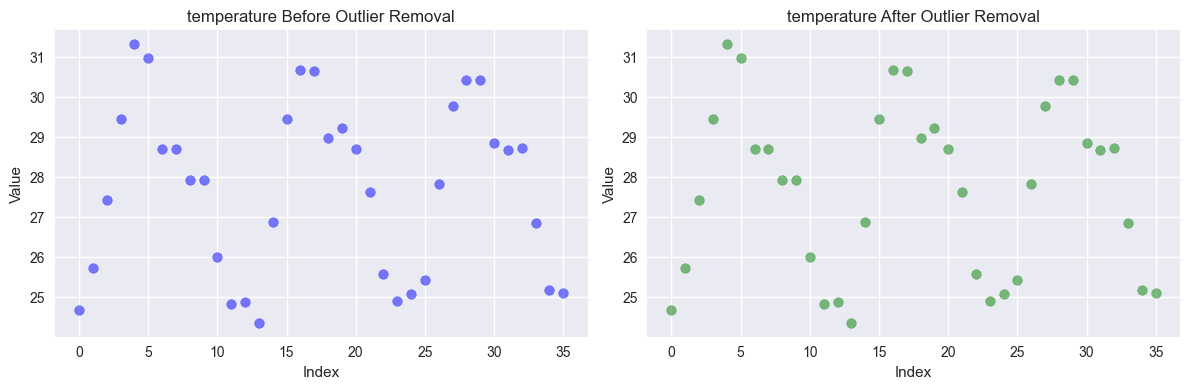

Number of outliers removed in temperature: 0


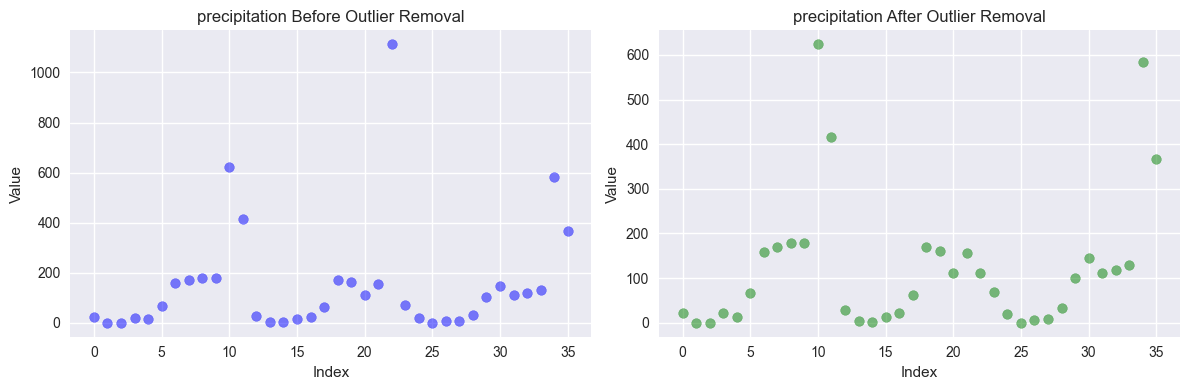

Number of outliers removed in precipitation: 1


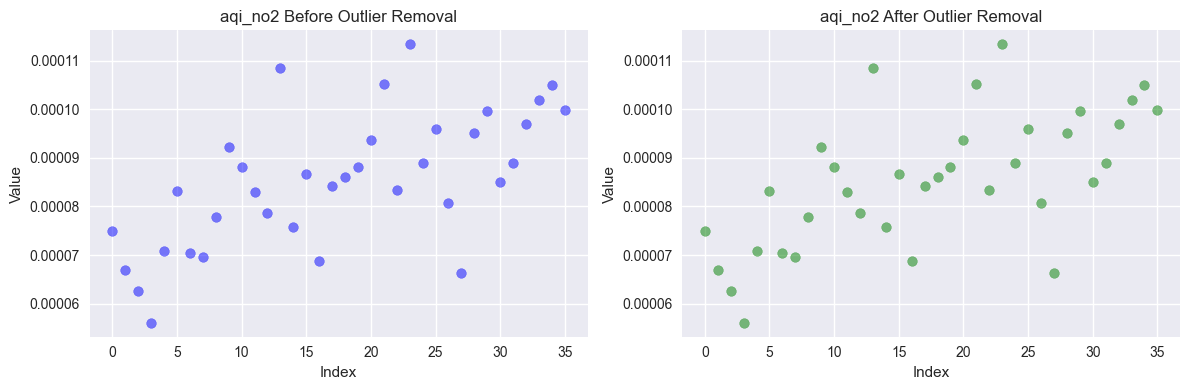

Number of outliers removed in aqi_no2: 0


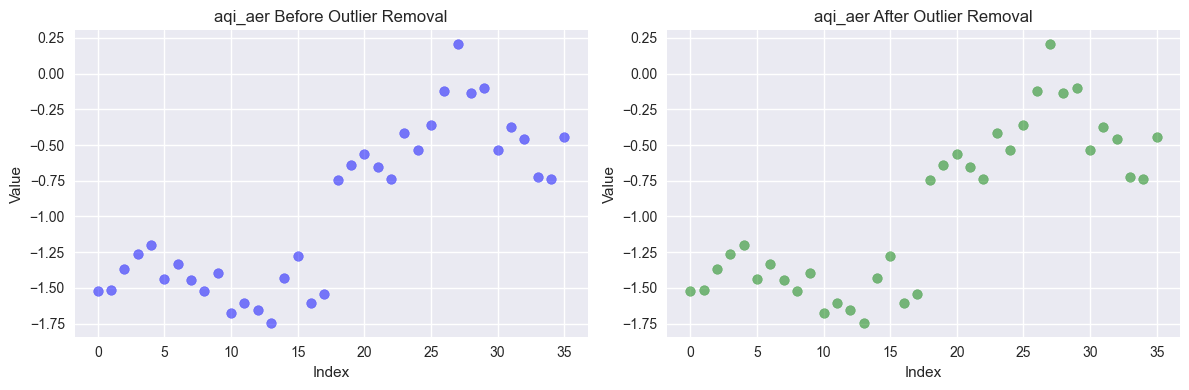

Number of outliers removed in aqi_aer: 0


In [24]:
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import pandas as pd

def remove_outliers(df, columns, threshold=3, min_std=1e-6):
    """
    Remove outliers from specified columns using z-score method and interpolate missing values.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame
    columns : list
        List of column names to process
    threshold : float, default=3
        Z-score threshold for outlier detection
    min_std : float, default=1e-6
        Minimum standard deviation threshold to apply outlier detection
    """
    df_no_outliers = df.copy()
    
    for column in columns:
        # Check if the column has enough variation to justify outlier removal
        std = df[column].std()
        if std < min_std:
            print(f"Warning: Column {column} has very low variation (std={std:.2e}). Skipping outlier removal.")
            continue
            
        valid_data = df_no_outliers[column].dropna()
        
        # Only proceed with outlier removal if we have enough variation
        z_scores = zscore(valid_data)
        mask = abs(z_scores) < threshold
        
        # Count potential outliers before removing them
        n_outliers = (~mask).sum()
        if n_outliers / len(mask) > 0.5:  # If more than 50% would be removed
            print(f"Warning: Too many outliers detected in {column} ({n_outliers} points). Skipping outlier removal.")
            continue
            
        # Create a full-length mask matching the original column
        full_mask = pd.Series(True, index=df_no_outliers.index)
        full_mask[valid_data.index] = mask
        
        # Mark outliers as NaN
        df_no_outliers.loc[~full_mask, column] = np.nan
        
        # Interpolate missing values
        df_no_outliers[column] = df_no_outliers[column].interpolate(
            method='linear', 
            limit_direction='both'
        )
        
        # Visualization
        plt.figure(figsize=(12, 4))
        
        plt.subplot(121)
        plt.scatter(df[column].index, df[column], alpha=0.5, color='blue')
        plt.title(f'{column} Before Outlier Removal')
        plt.xlabel('Index')
        plt.ylabel('Value')
        
        plt.subplot(122)
        plt.scatter(df_no_outliers[column].index, df_no_outliers[column], 
                   alpha=0.5, color='green')
        plt.title(f'{column} After Outlier Removal')
        plt.xlabel('Index')
        plt.ylabel('Value')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Number of outliers removed in {column}: {n_outliers}")
    
    return df_no_outliers
# Example usage:
df_no_outliers = remove_outliers(df_cleaned, variables)

In [25]:
# Add this diagnostic code before calling remove_outliers
def diagnose_data(df, columns):
    print("\nData Diagnosis:")
    print("-" * 50)
    for column in columns:
        print(f"\nColumn: {column}")
        print(f"First few values: {df[column].head().tolist()}")
        print(f"Unique values count: {df[column].nunique()}")
        print(f"Min: {df[column].min()}")
        print(f"Max: {df[column].max()}")
        print(f"Mean: {df[column].mean()}")
        print(f"Std: {df[column].std()}")

# Use it before outlier removal
diagnose_data(df_cleaned, variables)


Data Diagnosis:
--------------------------------------------------

Column: NDVI
First few values: [0.0494527778054777, 0.07200832602897365, 0.08304856577755537, 0.1178381682322678, 0.11107131439433895]
Unique values count: 36
Min: -0.16097305594382194
Max: 0.2810065704084995
Mean: 0.08655256050445909
Std: 0.07066245261571552

Column: temperature
First few values: [24.674856032795333, 25.731219947368345, 27.422403201377676, 29.453381466752546, 31.31817317201893]
Unique values count: 36
Min: 24.366075096428915
Max: 31.31817317201893
Mean: 27.722831148563856
Std: 2.1302179580029383

Column: precipitation
First few values: [22.157360126810765, 0.0, 0.0, 21.0614983858953, 13.23477252242347]
Unique values count: 35
Min: 0.0
Max: 1112.384601706435
Mean: 149.41795002025734
Std: 224.88786581422403

Column: aqi_no2
First few values: [7.496461693742695e-05, 6.700128168276307e-05, 6.259091378398896e-05, 5.603307447968007e-05, 7.079583130824504e-05]
Unique values count: 36
Min: 5.603307447968007e

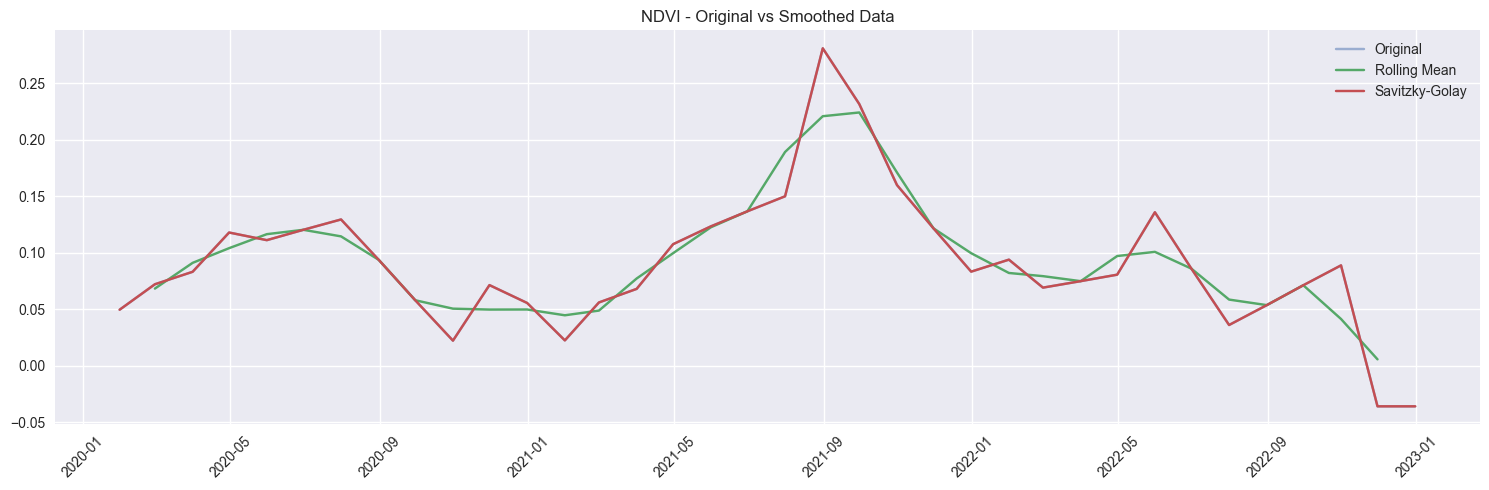

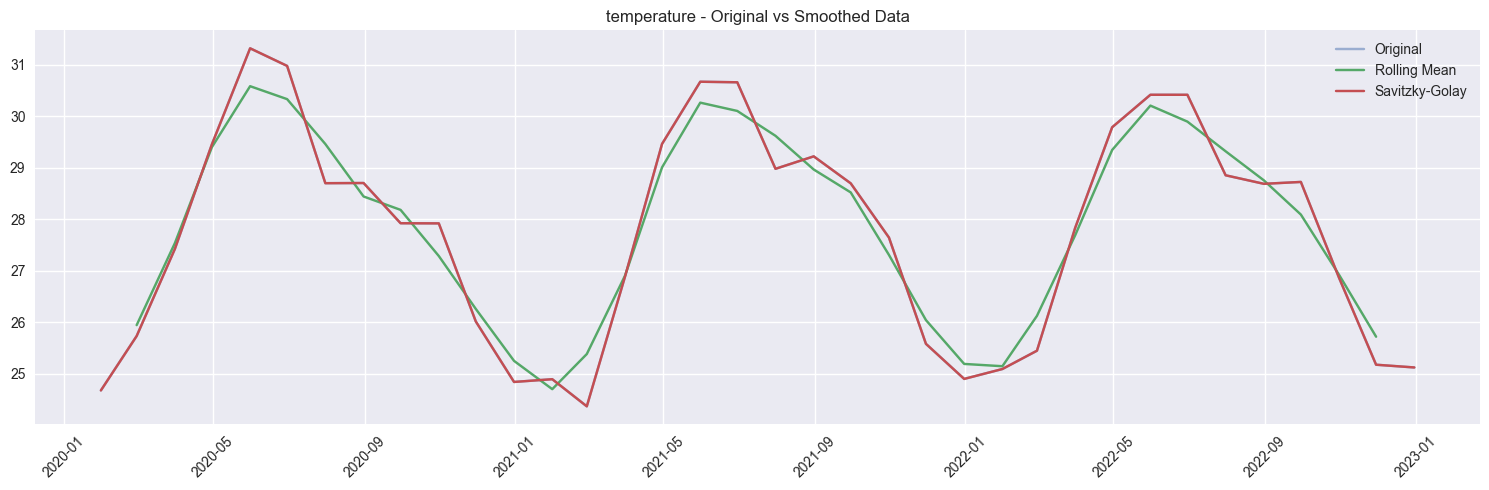

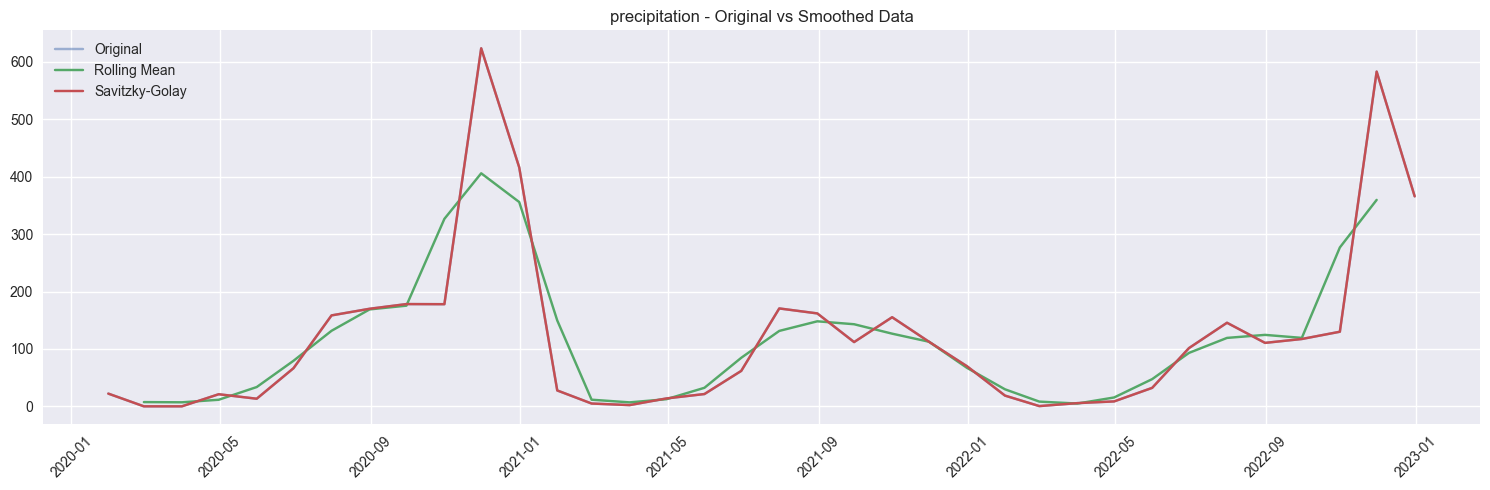

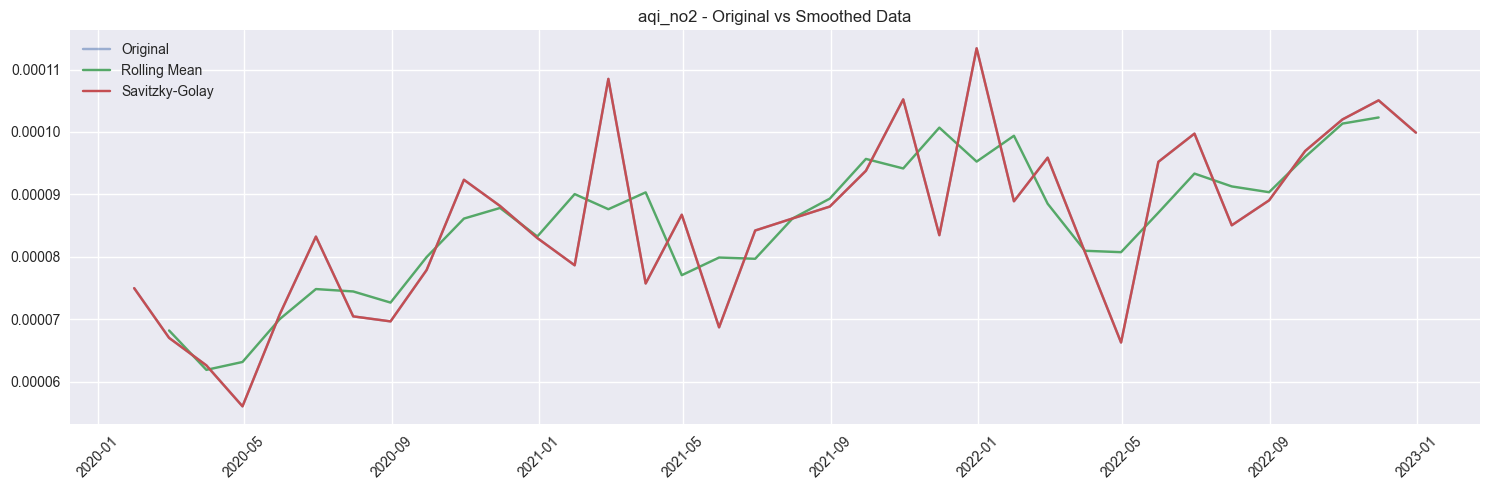

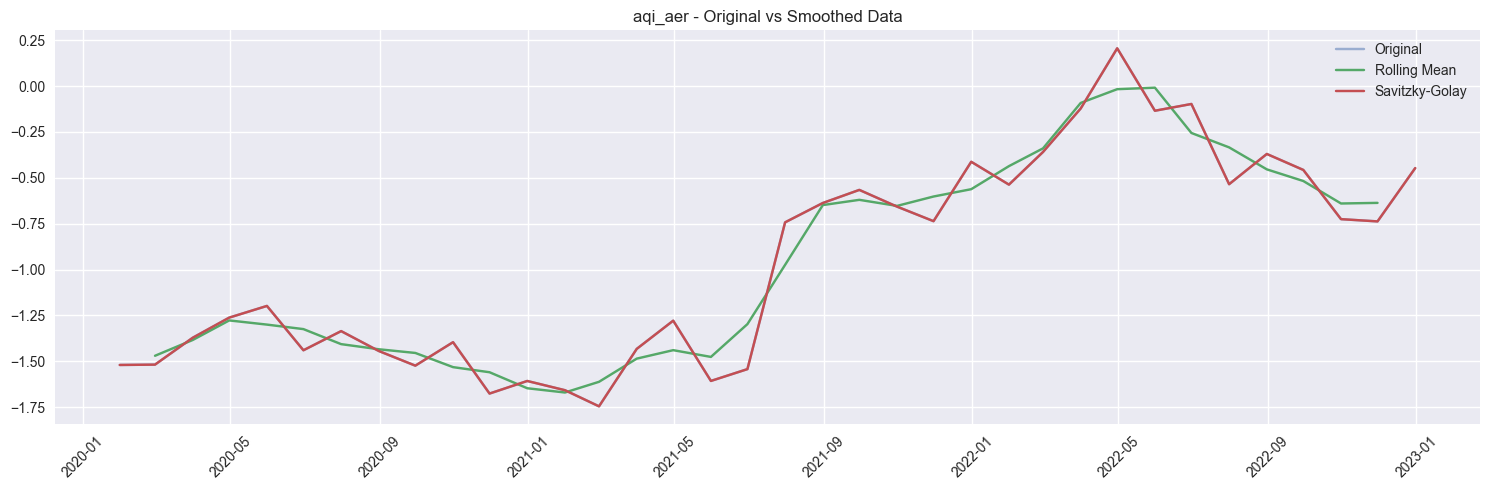

In [26]:
# Preprocessing Step 3: Data Smoothing
def apply_smoothing(df, columns, window_size=3):
    df_smoothed = df.copy()
    
    for column in columns:
        # Apply rolling mean
        df_smoothed[f'{column}_smoothed'] = df_smoothed[column].rolling(
            window=window_size, center=True).mean()
        
        # Apply Savitzky-Golay filter
        df_smoothed[f'{column}_sg'] = signal.savgol_filter(
            df_smoothed[column], 
            window_length=window_size + (1 - window_size % 2), 
            polyorder=2)
        
        # Visualization
        plt.figure(figsize=(15, 5))
        plt.plot(df_smoothed['date'], df_smoothed[column], 
                label='Original', alpha=0.5)
        plt.plot(df_smoothed['date'], df_smoothed[f'{column}_smoothed'], 
                label='Rolling Mean')
        plt.plot(df_smoothed['date'], df_smoothed[f'{column}_sg'], 
                label='Savitzky-Golay')
        plt.title(f'{column} - Original vs Smoothed Data')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    return df_smoothed

df_smoothed = apply_smoothing(df_no_outliers, variables)

Starting seasonal decomposition...
Input columns: ['NDVI', 'temperature', 'precipitation', 'aqi_no2', 'aqi_aer']

Processing NDVI...


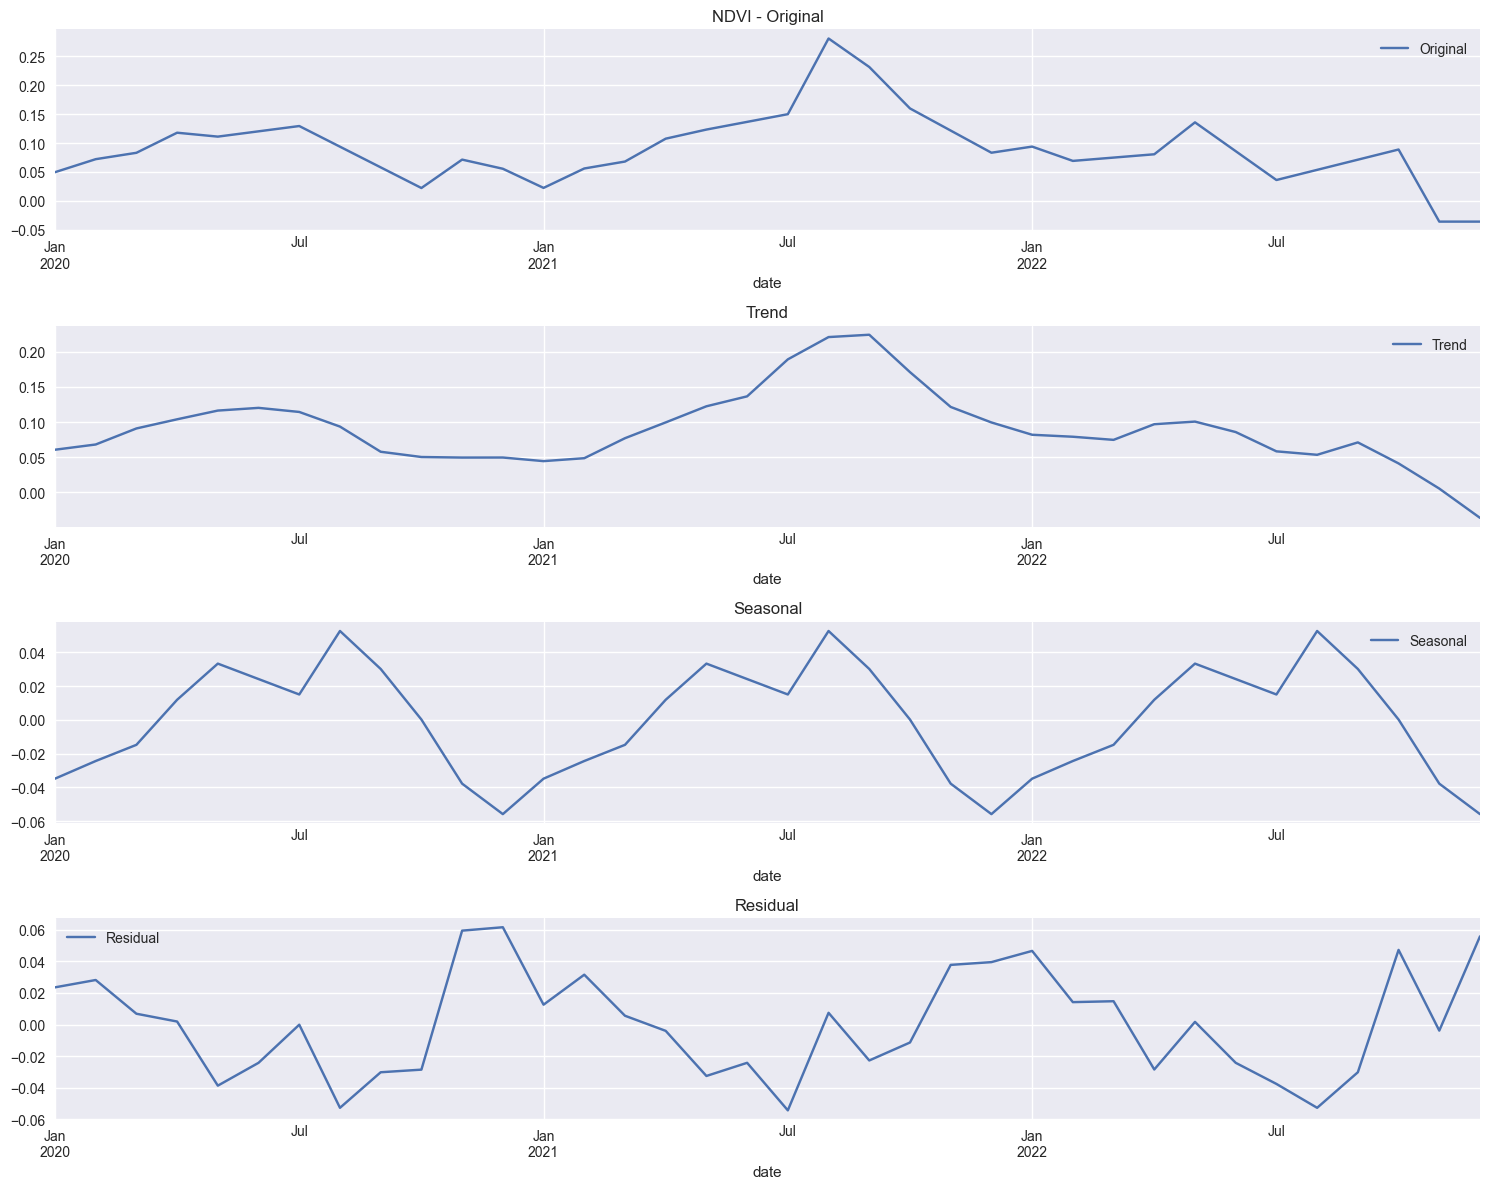


Component Statistics for NDVI:
Original mean: 0.090
Trend range: [-0.036, 0.224]
Seasonal range: [-0.056, 0.053]
Residual std: 0.033

Processing temperature...


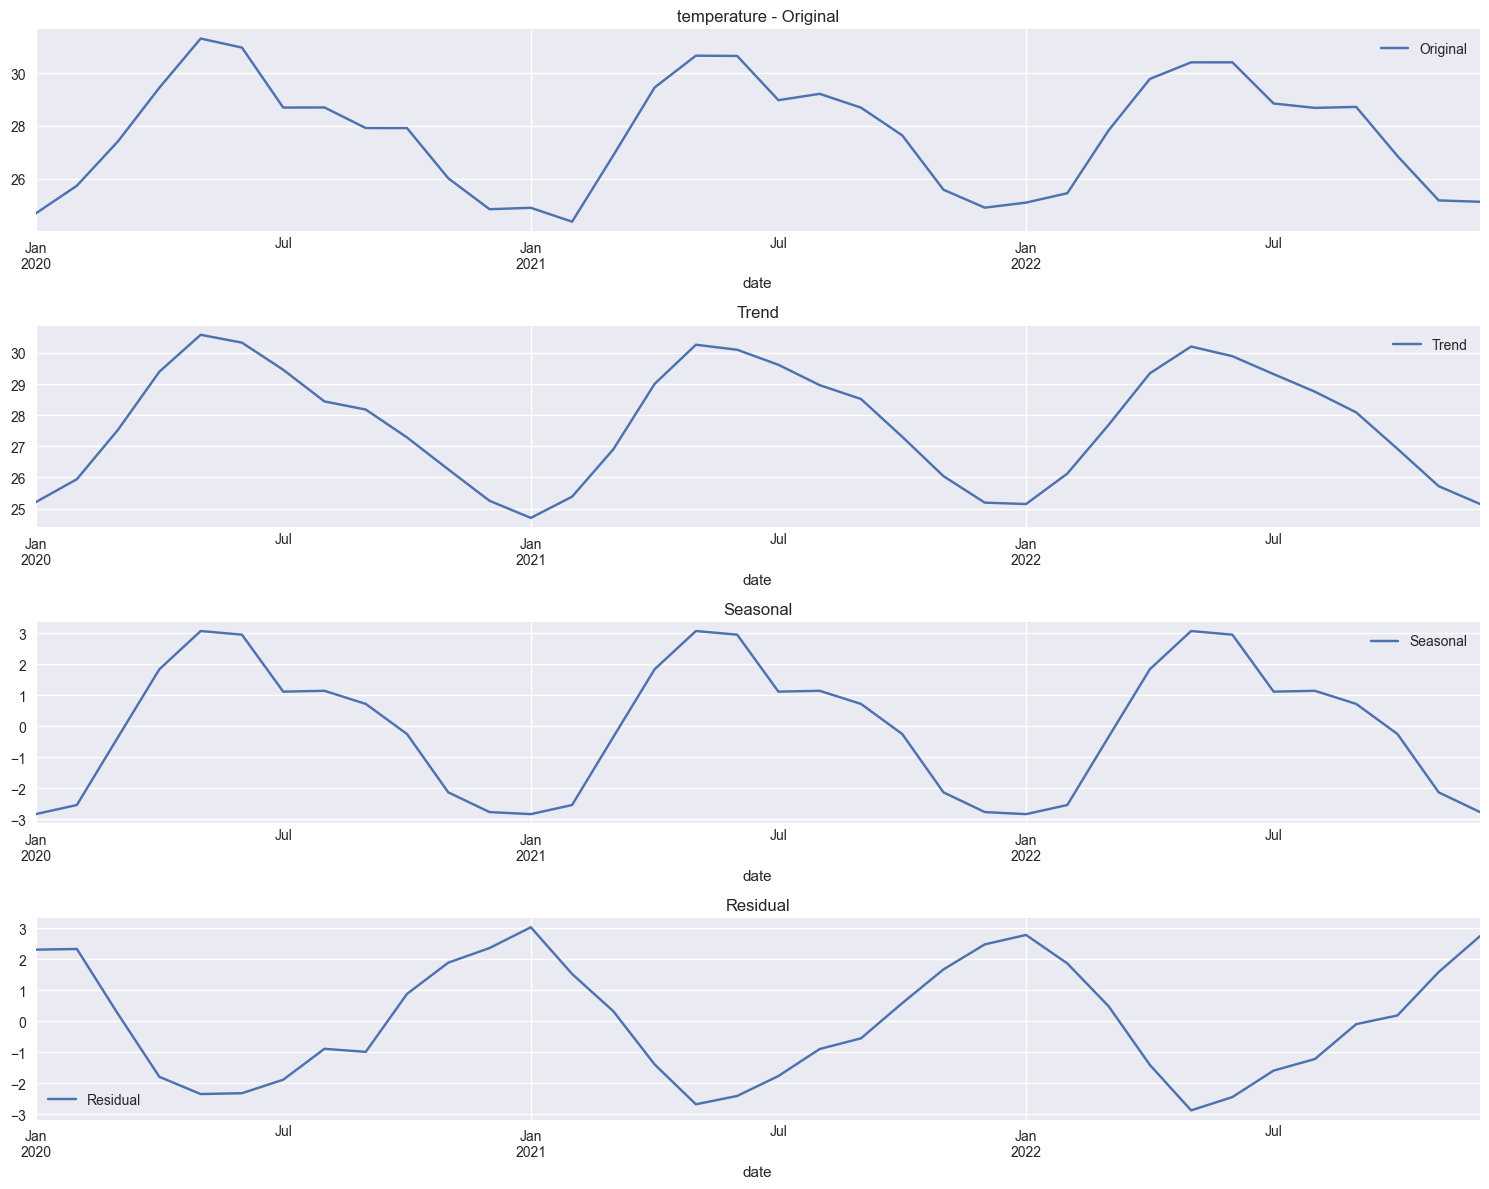


Component Statistics for temperature:
Original mean: 27.723
Trend range: [24.699, 30.583]
Seasonal range: [-2.837, 3.078]
Residual std: 1.865

Processing precipitation...


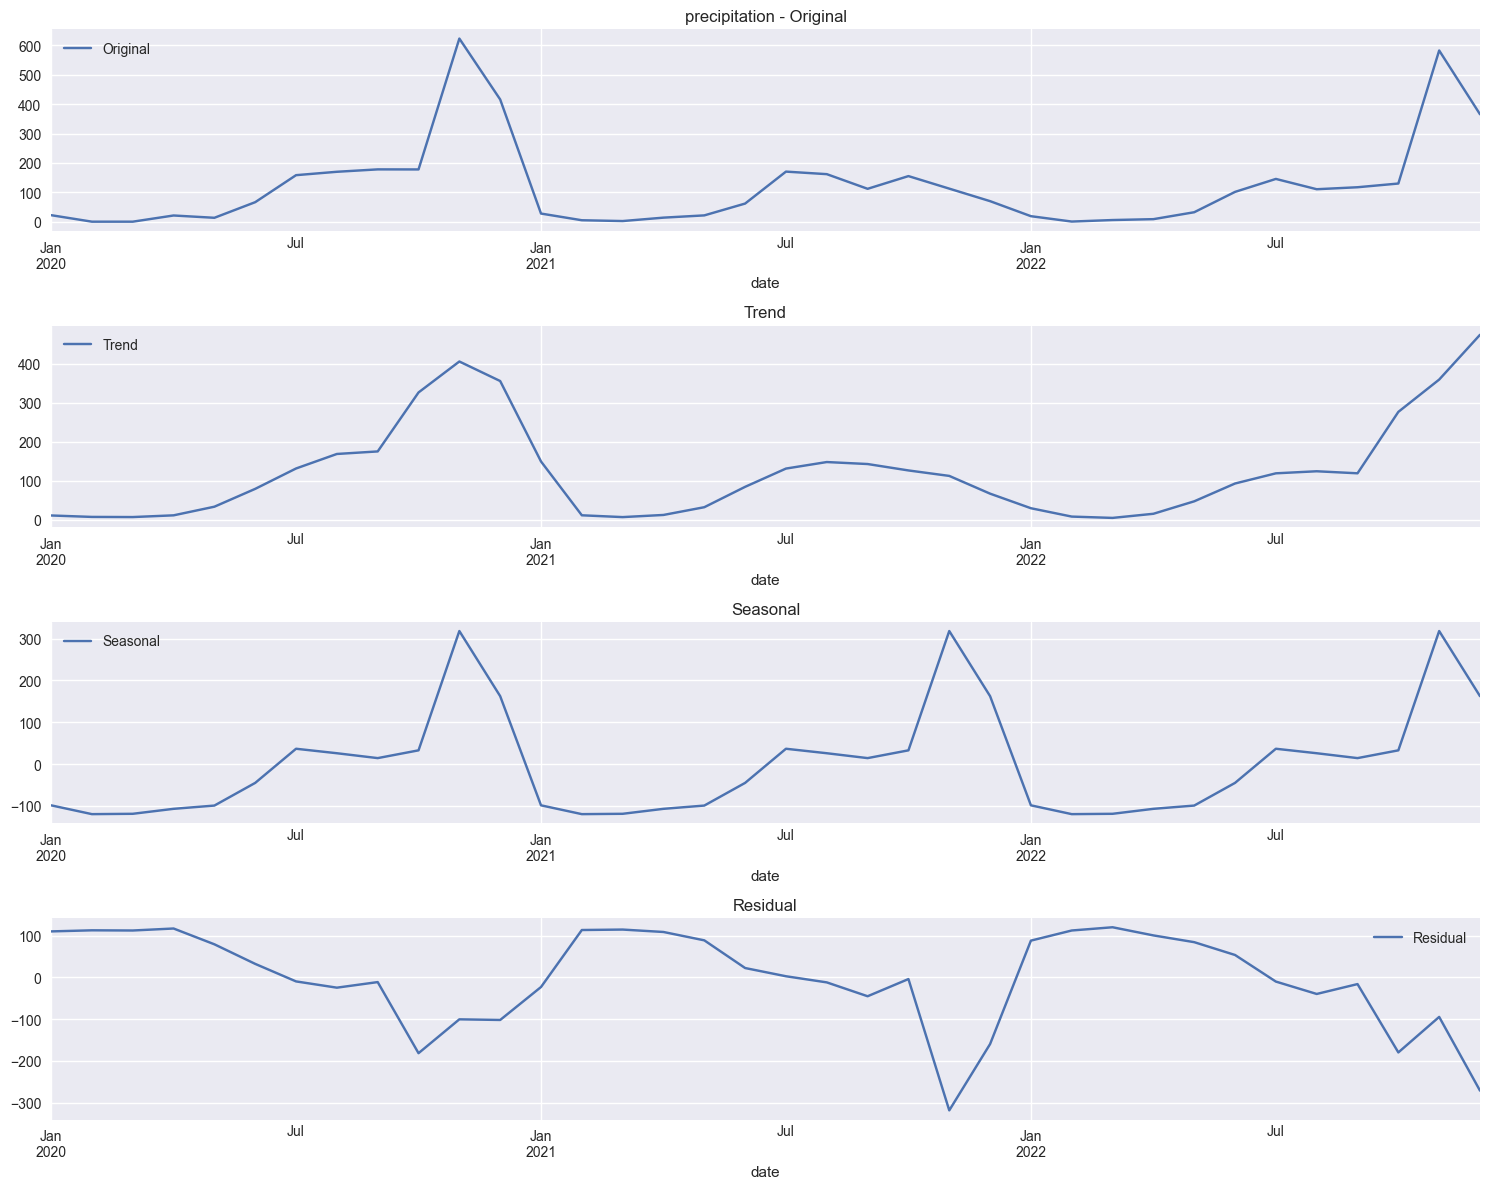


Component Statistics for precipitation:
Original mean: 121.645
Trend range: [4.848, 474.381]
Seasonal range: [-119.884, 318.072]
Residual std: 114.498

Processing aqi_no2...


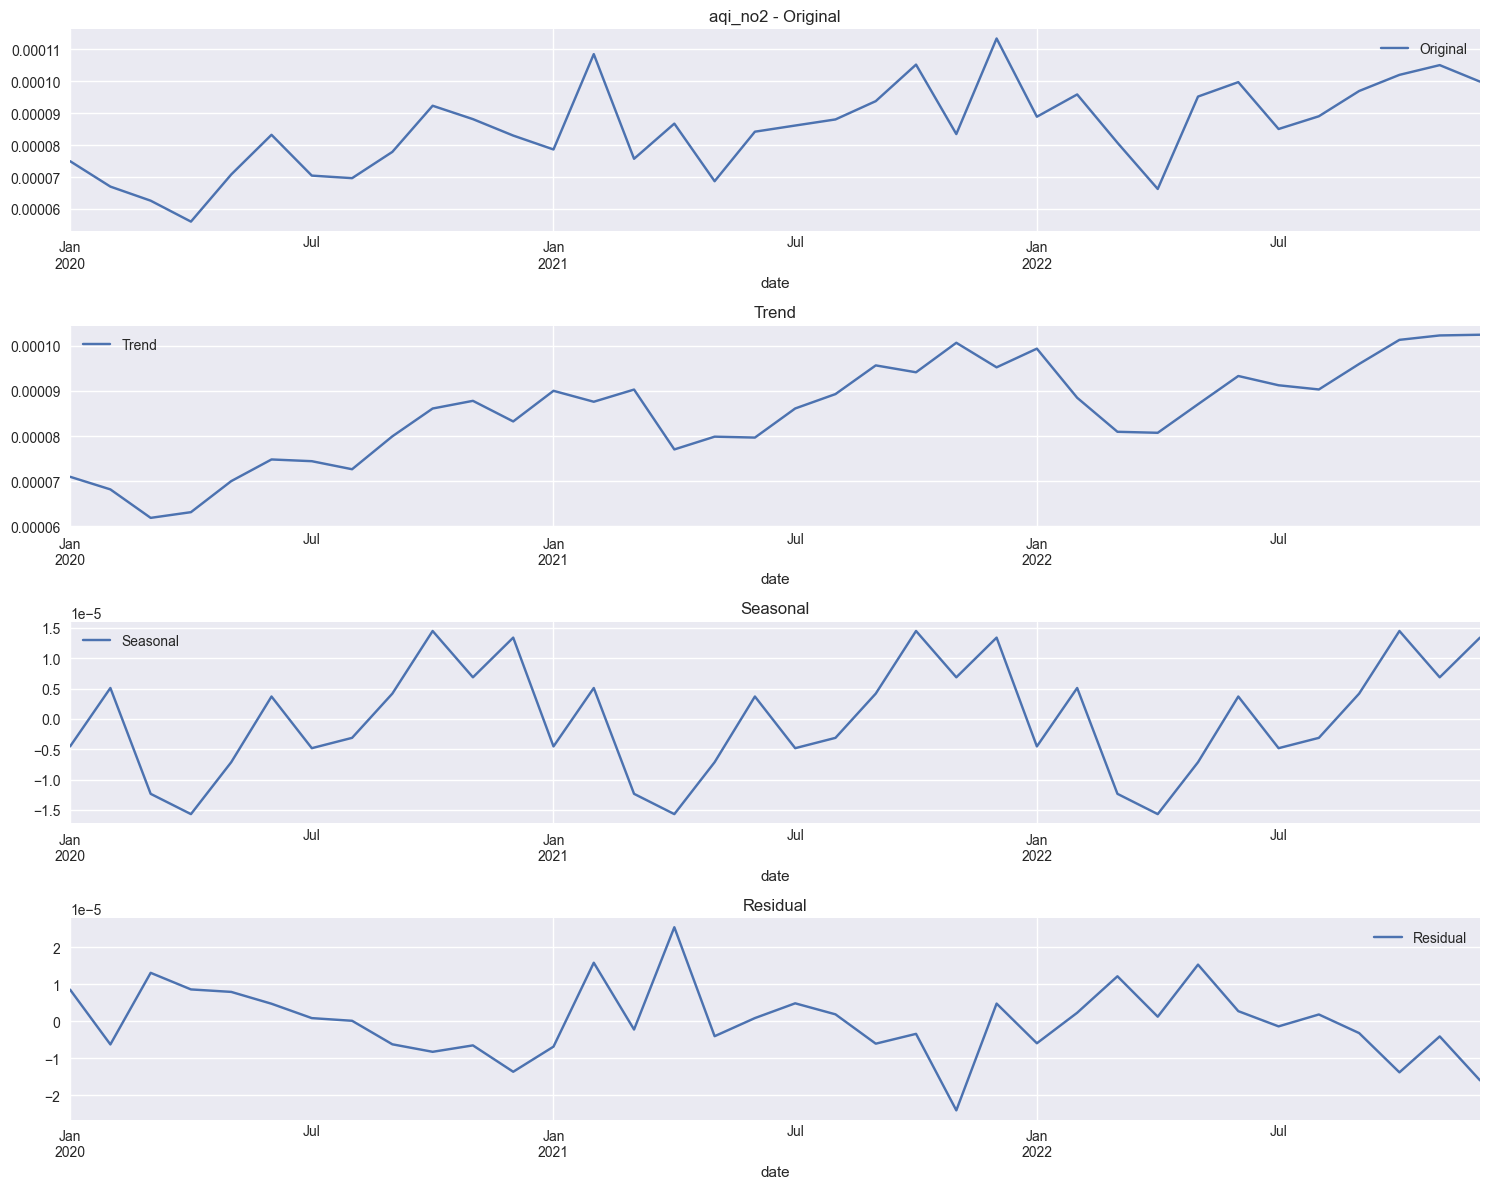


Component Statistics for aqi_no2:
Original mean: 0.000
Trend range: [0.000, 0.000]
Seasonal range: [-0.000, 0.000]
Residual std: 0.000

Processing aqi_aer...


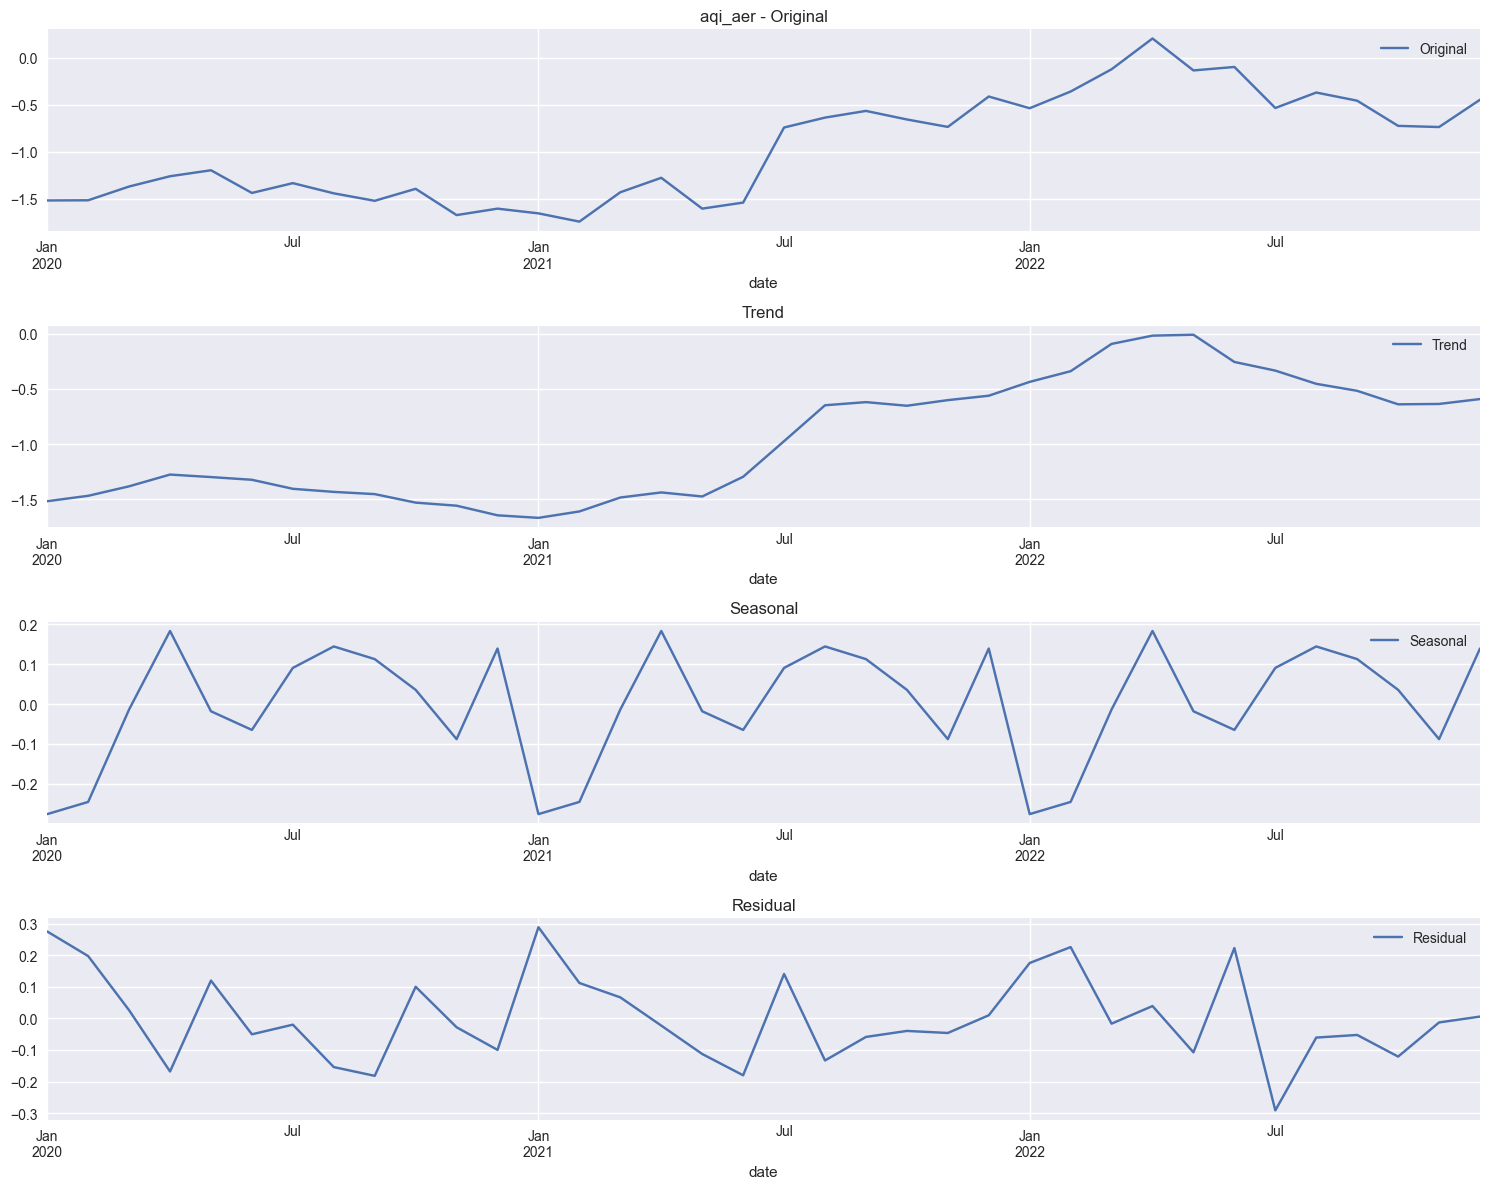


Component Statistics for aqi_aer:
Original mean: -0.962
Trend range: [-1.670, -0.009]
Seasonal range: [-0.276, 0.183]
Residual std: 0.139

Decomposition completed successfully


In [27]:
def decompose_seasonal(df, columns):
    # Create a copy and set date as index
    df_decomposed = df.copy()
    df_decomposed.set_index('date', inplace=True)
    
    for column in columns:
        print(f"\nProcessing {column}...")
        
        # Get the main series
        ts = df_decomposed[column].copy()
        
        # 1. Calculate trend using rolling mean
        window_size = 3
        trend = ts.rolling(window=window_size, center=True).mean()
        # Handle edge values
        trend.iloc[0] = ts.iloc[0:2].mean()
        trend.iloc[-1] = ts.iloc[-2:].mean()
        df_decomposed[f'{column}_trend'] = trend
        
        # 2. Calculate detrended series
        detrended = ts - trend
        
        # 3. Calculate seasonal pattern
        # Using month numbers directly from index
        monthly_means = pd.Series(index=range(1,13))
        for month in range(1,13):
            month_data = ts[ts.index.month == month]
            monthly_means[month] = month_data.mean()
        
        # Center the seasonal pattern
        seasonal_pattern = monthly_means - monthly_means.mean()
        
        # Create seasonal component
        seasonal = pd.Series(index=ts.index)
        for month in range(1,13):
            mask = ts.index.month == month
            seasonal[mask] = seasonal_pattern[month]
        df_decomposed[f'{column}_seasonal'] = seasonal
        
        # 4. Calculate residual
        df_decomposed[f'{column}_residual'] = detrended - seasonal
        
        # Create visualization
        fig, axes = plt.subplots(4, 1, figsize=(15, 12))
        
        # Original
        ts.plot(ax=axes[0], label='Original')
        axes[0].set_title(f'{column} - Original')
        axes[0].legend()
        
        # Trend
        trend.plot(ax=axes[1], label='Trend')
        axes[1].set_title('Trend')
        axes[1].legend()
        
        # Seasonal
        seasonal.plot(ax=axes[2], label='Seasonal')
        axes[2].set_title('Seasonal')
        axes[2].legend()
        
        # Residual
        df_decomposed[f'{column}_residual'].plot(ax=axes[3], label='Residual')
        axes[3].set_title('Residual')
        axes[3].legend()
        
        plt.tight_layout()
        plt.show()
        
        # Print statistics with NaN handling
        print(f"\nComponent Statistics for {column}:")
        print(f"Original mean: {ts.mean():.3f}")
        print(f"Trend range: [{trend.min():.3f}, {trend.max():.3f}]")
        print(f"Seasonal range: [{seasonal.min():.3f}, {seasonal.max():.3f}]")
        print(f"Residual std: {df_decomposed[f'{column}_residual'].std():.3f}")
    
    # Reset index for return
    df_decomposed = df_decomposed.reset_index()
    return df_decomposed

# Run the decomposition
try:
    print("Starting seasonal decomposition...")
    print(f"Input columns: {variables}")
    df_decomposed = decompose_seasonal(df_smoothed, variables)
    print("\nDecomposition completed successfully")
    
except Exception as e:
    print(f"\nError in decomposition:")
    print(str(e))

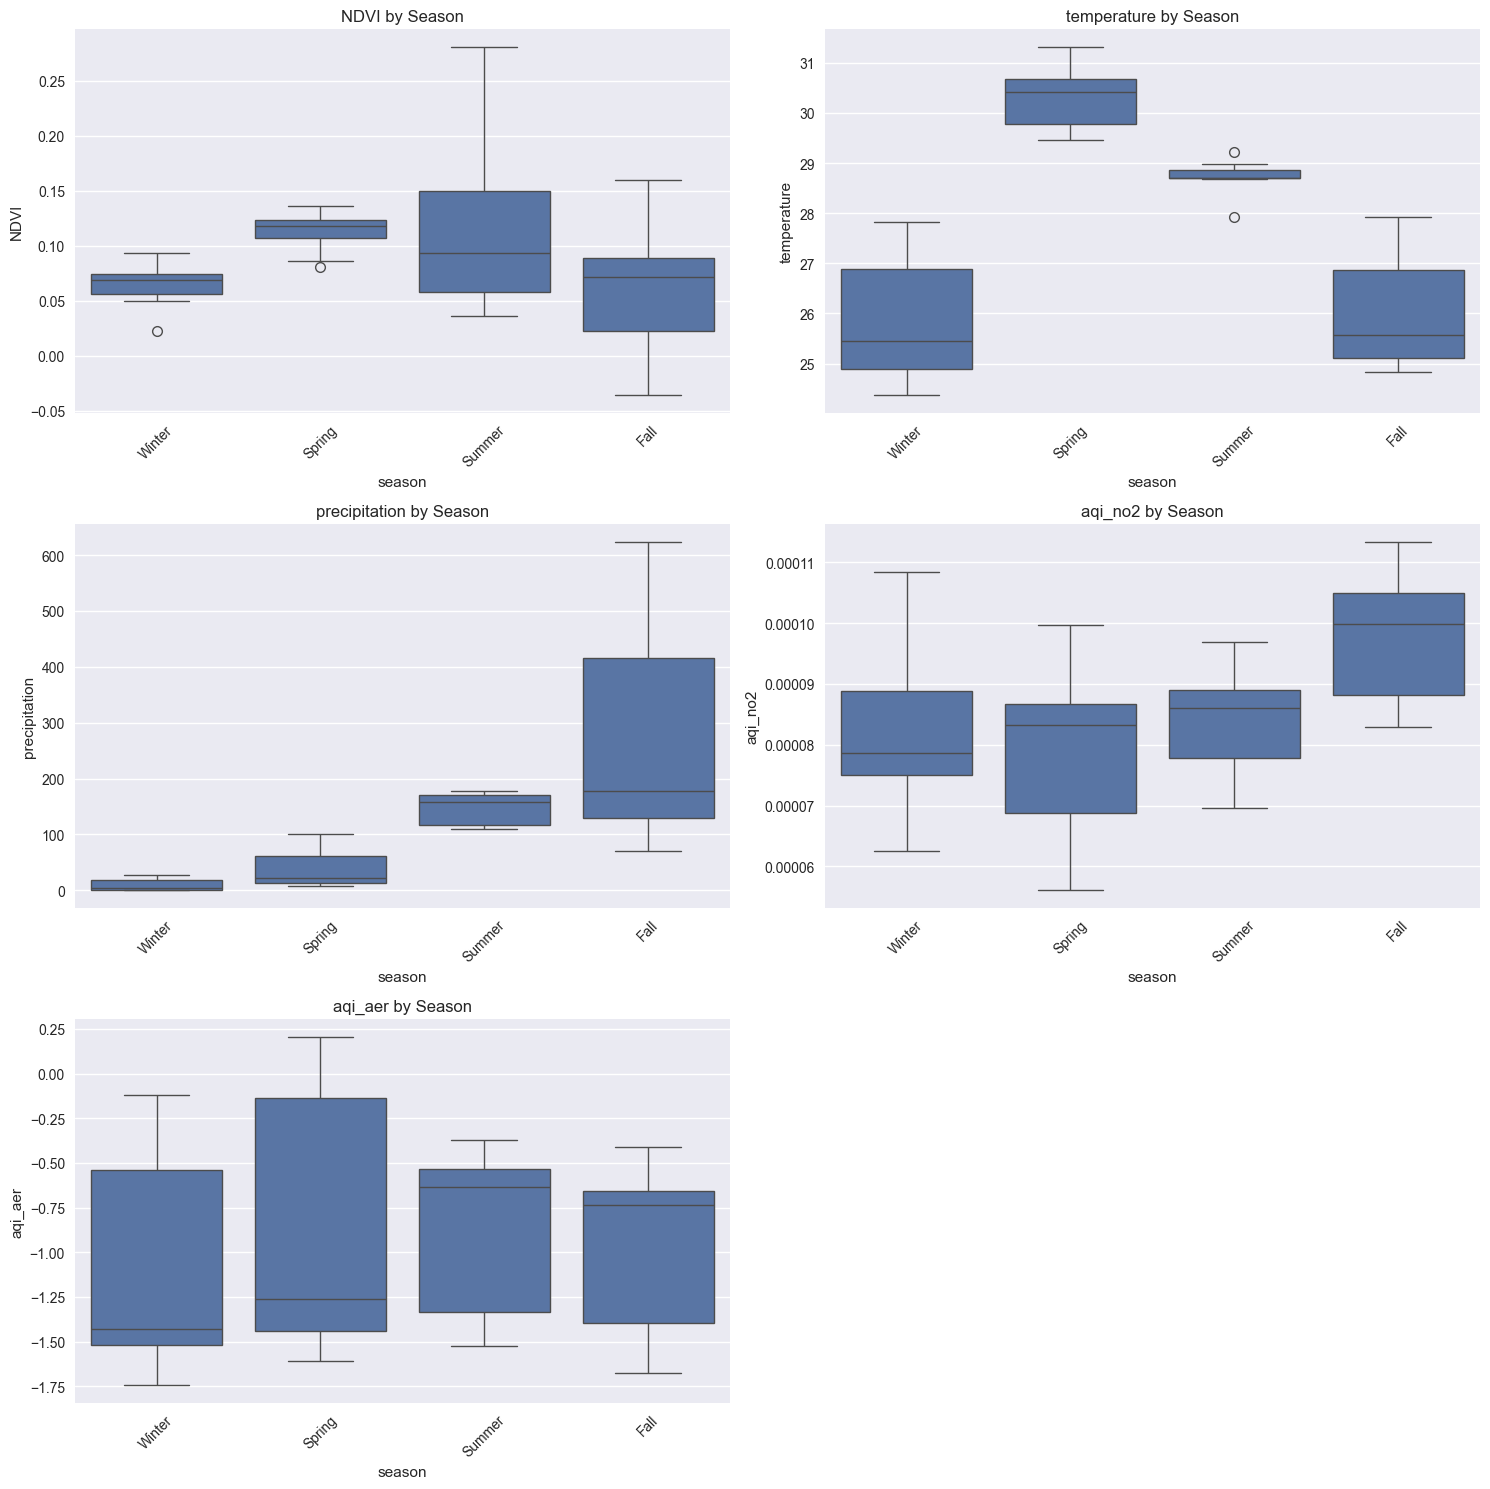

In [28]:
def engineer_features(df):
    # Only using these variables
    variables = ['NDVI', 'temperature', 'precipitation', 'aqi_no2', 'aqi_aer']
    
    df_engineered = df.copy()
    
    # Temporal features
    df_engineered['month'] = df_engineered['date'].dt.month
    df_engineered['season'] = pd.cut(df_engineered['month'], 
                                   bins=[0, 3, 6, 9, 12], 
                                   labels=['Winter', 'Spring', 'Summer', 'Fall'])
    
    # Rolling statistics
    for column in variables:
        df_engineered[f'{column}_roll_mean'] = df_engineered[column].rolling(window=2).mean()
    
    
    return df_engineered

df_engineered = engineer_features(df_decomposed)

# Calculate number of rows needed for subplots
n_vars = len(variables)
n_rows = (n_vars + 1) // 2  # Ceiling division to get number of rows needed
n_cols = min(2, n_vars)     # Use 2 columns unless we only have 1 variable

# Visualize seasonal patterns
plt.figure(figsize=(15, 5*n_rows))
for i, var in enumerate(variables, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=df_engineered, x='season', y=var)
    plt.title(f'{var} by Season')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Training models for NDVI...


c:\Users\dhani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\dhani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an intege

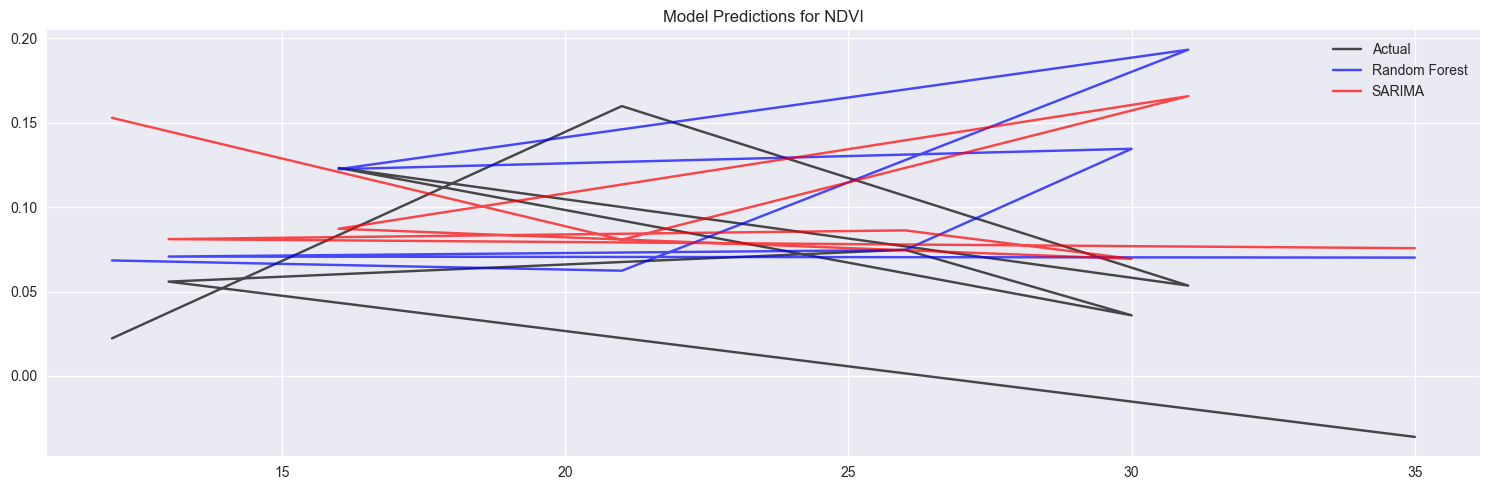


Model Performance for NDVI:
Random Forest - RMSE: 0.0809, R²: -1.0567
SARIMA - RMSE: 0.0803, R²: -1.0257

Training models for temperature...


c:\Users\dhani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\dhani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an intege

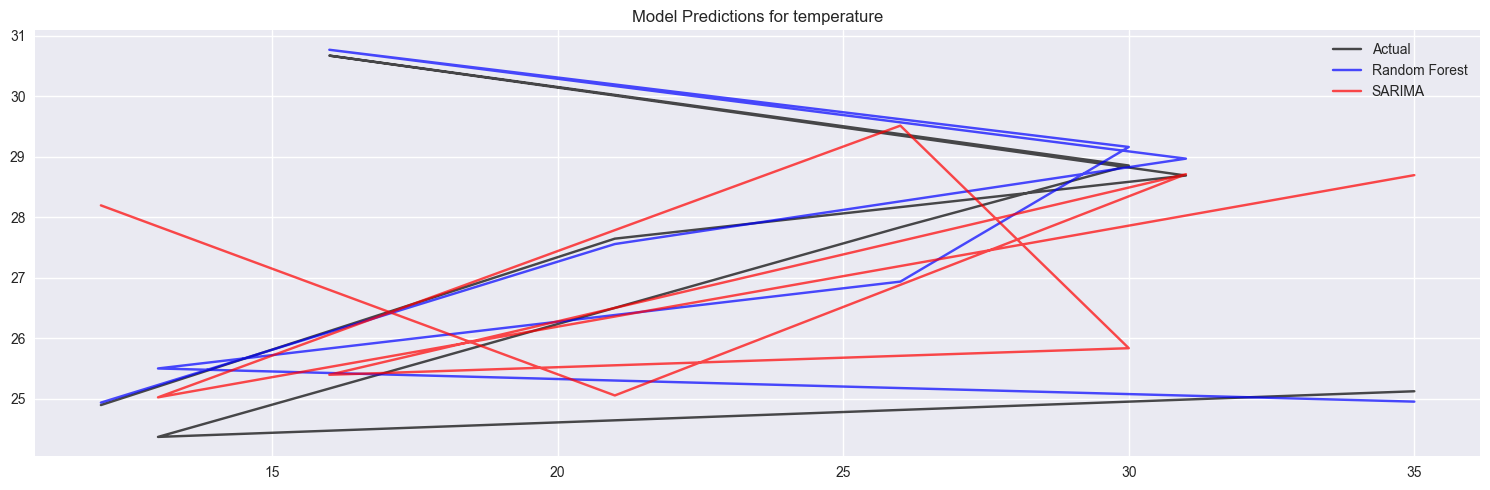


Model Performance for temperature:
Random Forest - RMSE: 0.5371, R²: 0.9345
SARIMA - RMSE: 2.9704, R²: -1.0039

Training models for precipitation...


c:\Users\dhani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\dhani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

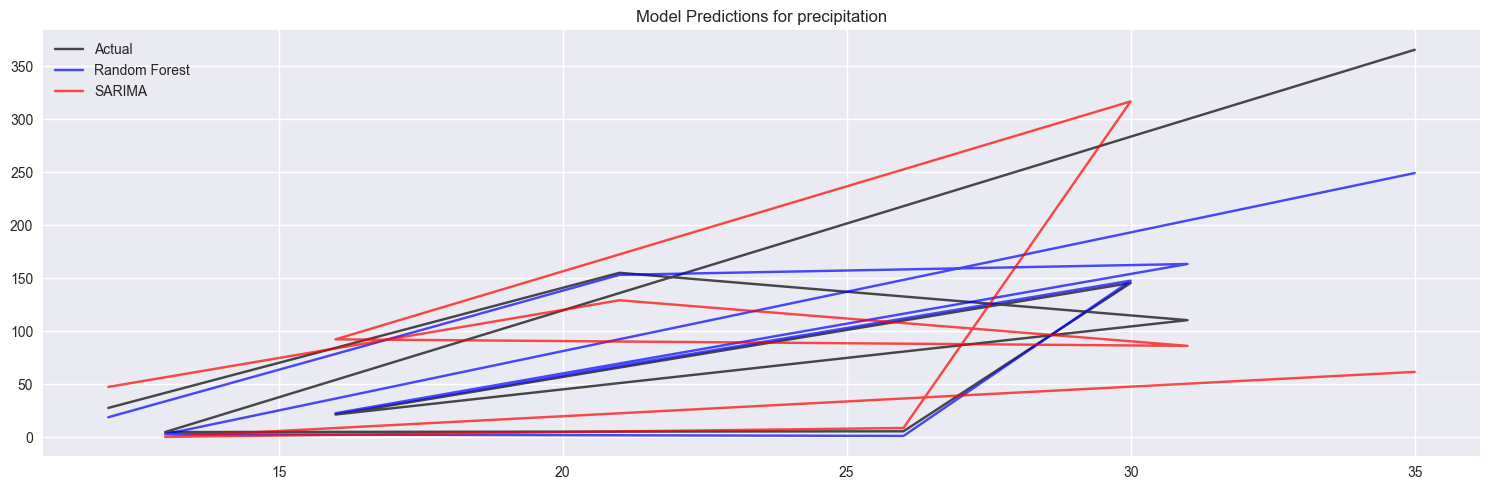


Model Performance for precipitation:
Random Forest - RMSE: 45.3641, R²: 0.8433
SARIMA - RMSE: 126.7764, R²: -0.2238

Training models for aqi_no2...


c:\Users\dhani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\dhani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

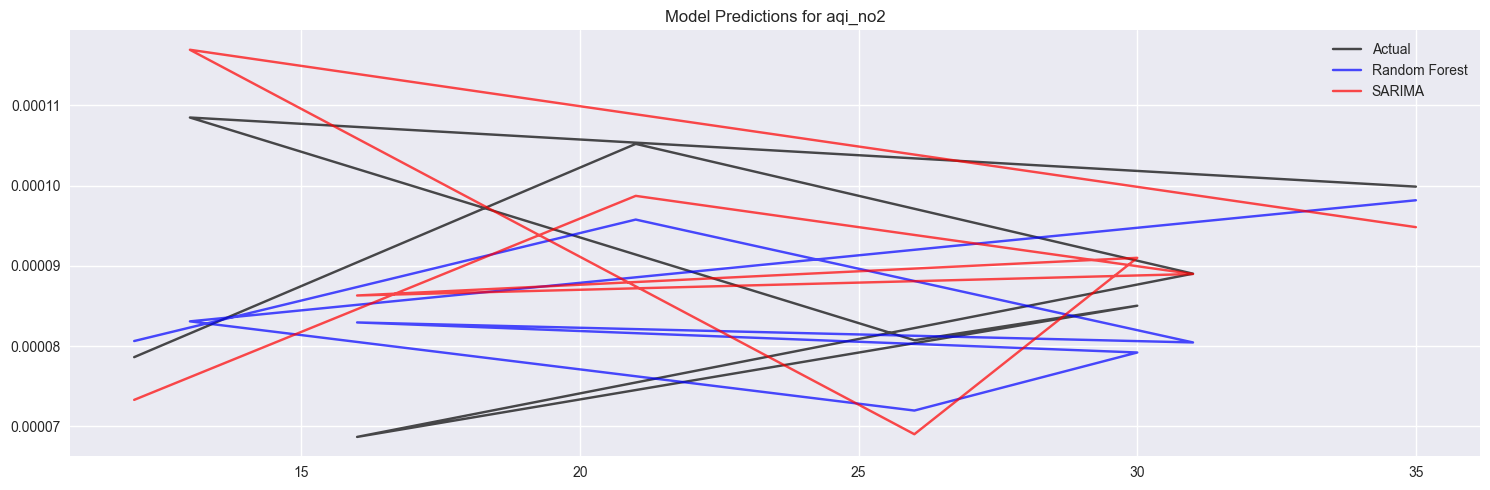


Model Performance for aqi_no2:
Random Forest - RMSE: 0.0000, R²: 0.1719
SARIMA - RMSE: 0.0000, R²: 0.5228

Training models for aqi_aer...


c:\Users\dhani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dhani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\dhani\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an intege

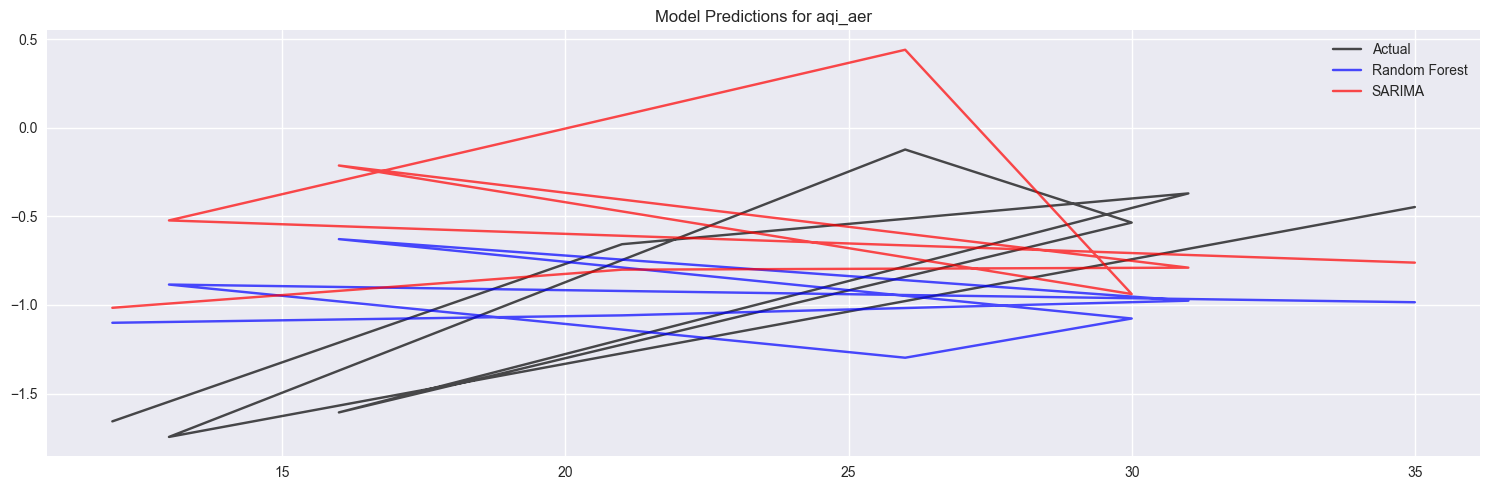


Model Performance for aqi_aer:
Random Forest - RMSE: 0.7500, R²: -0.4659
SARIMA - RMSE: 0.7602, R²: -0.5063


In [29]:
# Prepare data for modeling
def prepare_modeling_data(df, target_variable):
    # For each variable, we only use its own historical features and month
    feature_cols = ['month']
    
    X = df[feature_cols]
    y = df[target_variable]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test, feature_cols

def train_and_evaluate_models(X_train, X_test, y_train, y_test, target_variable):
    # Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
    rf_r2 = r2_score(y_test, rf_pred)
    
    # SARIMA
    sarima_model = SARIMAX(y_train, order=(1, 1, 1), 
                          seasonal_order=(1, 1, 1, 12))
    sarima_fitted = sarima_model.fit(disp=False)
    sarima_pred = sarima_fitted.forecast(len(y_test))
    sarima_rmse = np.sqrt(mean_squared_error(y_test, sarima_pred))
    sarima_r2 = r2_score(y_test, sarima_pred)
    
    # Plot results
    plt.figure(figsize=(15, 5))
    plt.plot(y_test.index, y_test, 'k-', label='Actual', alpha=0.7)
    plt.plot(y_test.index, rf_pred, 'b-', label='Random Forest', alpha=0.7)
    plt.plot(y_test.index, sarima_pred, 'r-', label='SARIMA', alpha=0.7)
    plt.title(f'Model Predictions for {target_variable}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    print(f"\nModel Performance for {target_variable}:")
    print(f"Random Forest - RMSE: {rf_rmse:.4f}, R²: {rf_r2:.4f}")
    print(f"SARIMA - RMSE: {sarima_rmse:.4f}, R²: {sarima_r2:.4f}")
    
    return rf_model, sarima_fitted, rf_rmse, sarima_rmse

# Train models for each variable
variables = ['NDVI', 'temperature', 'precipitation', 'aqi_no2', 'aqi_aer']
model_results = {}

for var in variables:
    print(f"\nTraining models for {var}...")
    X_train, X_test, y_train, y_test, feature_cols = prepare_modeling_data(df_engineered, var)
    
    rf_model, sarima_model, rf_rmse, sarima_rmse = train_and_evaluate_models(
        X_train, X_test, y_train, y_test, var
    )
    
    model_results[var] = {
        'random_forest': {'model': rf_model, 'rmse': rf_rmse},
        'sarima': {'model': sarima_model, 'rmse': sarima_rmse}
    }